In [1]:
from trainer import *
import cv2
import glob
from copy import deepcopy
from itertools import islice
from collections import deque
from mat4py import loadmat
from scipy import linalg

(576, 650, 3)

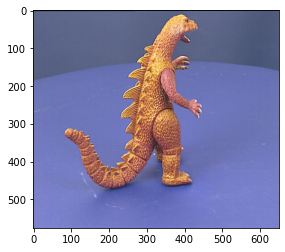

In [2]:
img = './images/viff.000.ppm'
dino = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)[:, :650]
plt.imshow(dino)
dino.shape

# Understand torch.grid_sample

In [3]:
input = torch.arange(4*4).view(1, 1, 4, 4).float()
print(input)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])


In [4]:
# Create grid to upsample input
d = torch.linspace(0, 11, 10)
meshx, meshy = torch.meshgrid((d, d))
grid = torch.stack((meshy, meshx), 2)
grid = grid.unsqueeze(0) # add batch dim

In [5]:
output = torch.nn.functional.grid_sample(input, grid, mode='bilinear')

/Users/lakshjaisinghani/miniforge3/lib/python3.9/site-packages/torch/nn/functional.py:3825: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


# Test with dinosaur data

In [72]:
class dino_dataset(Dataset):
    def __init__(self, transforms=None):
        self.transforms = transforms
        self.samples = []
        
        self.init_samples(2)
        
    def sliding_window(self, iterable, size):
        '''
            returns a iterable generator object 
            that is a sliding windowed list of length 
            `size`.
        '''
        iterable = iter(iterable)
        window = deque(islice(iterable, size), maxlen=size)
        for item in iterable:
            yield list(window)
            window.append(item)
        if window:  
            yield list(window)
            
    def init_pose(self):
        data = loadmat('./utils/dino_Ps.mat')['P']
        data = np.array(data)
        return data
    
    def factor_P(self, P):
        """  
            Factorize the camera matrix into K,R,t as P = K[R|t]. 
        """
        
        print(P)

        # factor first 3*3 part
        K,R = linalg.rq(P[:,:3])

        # make diagonal of K positive
        T = np.diag(np.sign(np.diag(K)))
        if linalg.det(T) < 0:
            T[1,1] *= -1

        self.K = torch.from_numpy(np.dot(K,T))
        self.R = torch.from_numpy(np.dot(T,R)) # T is its own inverse
        self.t = torch.from_numpy(np.dot(linalg.inv(self.K),P[:,3]))

        return self.K, self.R, self.t.reshape((3, 1))
            
    def init_samples(self, seq_size):
        img_dir = './images/*.ppm'
        
        poses = self.init_pose()
        
        x = sorted(glob.glob(img_dir))
        
        sample = {}
        for ind, window in enumerate(self.sliding_window(x, seq_size)):
            sample['tgt']  = window[0]
            sample['ref']  = window[1]
            sample['oxts'] = poses[ind]
            
            self.samples.append(deepcopy(sample))
            
    def load_img(self, img_dir):
        img = cv2.cvtColor(cv2.imread(img_dir), cv2.COLOR_BGR2RGB)
#         img = np.transpose(img, (2, 0, 1))

        # apply transforms
        if self.transforms:
            for t in self.transforms:
                img = t(img)

        return img
        
        
    def __getitem__(self, indx):
        ret_sample = {}
        sample = self.samples[indx]
        
        ret_sample['tgt'] = self.load_img(sample['tgt'])
        ret_sample['ref'] = self.load_img(sample['ref'])

        # decompose projection matrix 
        ret_sample['K'], ret_sample['R'], ret_sample['t'] = self.factor_P(sample['oxts'])
        decomp = cv2.decomposeProjectionMatrix(sample['oxts'])
        
        return ret_sample, decomp
        
    def __len__(self):
        return len(self.samples)

In [73]:
transform = [transforms.ToTensor()]
            

dataset = dino_dataset(transforms=transform)

In [74]:
len(dataset)

36

In [9]:
# for x in range(36):
#     samp = dataset.__getitem__(x)
#     print(samp['R'])

In [99]:
sample, decomp = dataset.__getitem__(10)
tgt  = sample['tgt'].unsqueeze(0)
ref  = sample['ref'].unsqueeze(0)
# K    = sample['K'].unsqueeze(0)
# K    = K/K[:, 2, 2] 
# R    = sample['R']
# t    = sample['t']
# T = -R.T * t

[[ 3.81411684e+01 -1.07211828e+01 -7.63289880e-01  3.95917551e+00]
 [ 1.55778602e+00  1.43767584e+01 -2.74509701e+01 -1.44294334e+01]
 [-2.25312139e-03 -1.20411202e-02 -5.69307087e-04  1.22493587e-02]]


In [119]:
t = torch.tensor((decomp[2]/decomp[2][3])[:3])
R = torch.tensor(decomp[1])
K = torch.tensor(decomp[0])


torch.Size([3, 1])

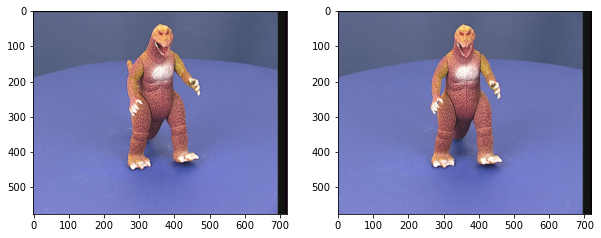

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10)) 
axs[0].imshow(np.transpose(tgt[0].cpu().numpy(), (1, 2, 0)))
axs[1].imshow(np.transpose(ref[0].cpu().numpy(), (1, 2, 0)))

In [121]:
from geometry.transform import  Transform
T = Transform()

W = tgt.shape[3]
H = tgt.shape[2]

grid = T.image_grid(1, tgt.shape[2], tgt.shape[3], tgt.dtype, tgt.device)
flat_grid = grid.view(1, 3, -1)  # [B,3,HW]

In [122]:
# convert to cam coords
xnorm = K.inverse().float() @ flat_grid.float()
xnorm = xnorm.view(1, 3, H, W)

In [123]:
xnorm

tensor([[[[ -6.4164,  -6.3910,  -6.3657,  ...,  11.7561,  11.7815,  11.8068],
          [ -6.4155,  -6.3902,  -6.3648,  ...,  11.7570,  11.7824,  11.8077],
          [ -6.4146,  -6.3893,  -6.3640,  ...,  11.7579,  11.7832,  11.8086],
          ...,
          [ -5.9184,  -5.8931,  -5.8677,  ...,  12.2541,  12.2795,  12.3048],
          [ -5.9175,  -5.8922,  -5.8668,  ...,  12.2550,  12.2803,  12.3057],
          [ -5.9167,  -5.8913,  -5.8660,  ...,  12.2559,  12.2812,  12.3066]],

         [[ 38.0794,  38.0794,  38.0794,  ...,  38.0794,  38.0794,  38.0794],
          [ 38.1150,  38.1150,  38.1150,  ...,  38.1150,  38.1150,  38.1150],
          [ 38.1505,  38.1505,  38.1505,  ...,  38.1505,  38.1505,  38.1505],
          ...,
          [ 58.4616,  58.4616,  58.4616,  ...,  58.4616,  58.4616,  58.4616],
          [ 58.4972,  58.4972,  58.4972,  ...,  58.4972,  58.4972,  58.4972],
          [ 58.5327,  58.5327,  58.5327,  ...,  58.5327,  58.5327,  58.5327]],

         [[-81.5439, -81.5439,

### cam -> img (no transform test)

In [124]:
# convert back to img coords
flat_cam_coords = xnorm.view(1, 3, -1)
X_img = K.float() @ flat_cam_coords.float()

# Normalize points
X = X_img[:, 0]
Y = X_img[:, 1]
Z = X_img[:, 2]

Xnorm = 2 * (X / Z) / (W - 1) - 1.
Ynorm = 2 * (Y / Z) / (H - 1) - 1.

# Return pixel coordinates
img_grid = torch.stack([Xnorm, Ynorm], dim=-1).view(1, H, W, 2).float()

In [125]:
projected_img = F.grid_sample(tgt.float(), img_grid, mode='bilinear', padding_mode='zeros', align_corners=True)

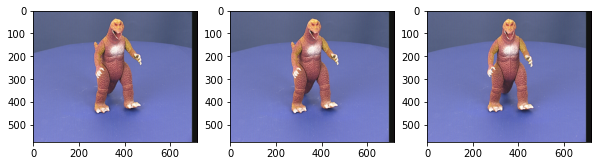

In [126]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10)) 
axs[0].imshow(np.transpose(tgt[0].cpu().numpy(), (1, 2, 0)))
axs[1].imshow(np.transpose(projected_img[0].cpu().numpy(), (1, 2, 0)))
axs[2].imshow(np.transpose(ref[0].cpu().numpy(), (1, 2, 0)))

### cam -> img (with transform)

In [127]:
R, t

(tensor([[ 0.9825, -0.1820, -0.0395],
         [-0.0304,  0.0529, -0.9981],
         [ 0.1837,  0.9819,  0.0464]], dtype=torch.float64),
 tensor([[ 1.7305e-01],
         [ 9.8491e-01],
         [-1.3607e-16]], dtype=torch.float64))

In [128]:
from geometry.pose_geometry import *

# transform to different 
flat_cam_coords = xnorm.view(1, 3, -1)
ext_vec = torch.ones(1, 414720).unsqueeze(0)

hom_flat_coords = torch.hstack((flat_cam_coords, ext_vec))

identity_rot = R.float()  # torch.eye(3).unsqueeze(0)

# P         = torch.cat((identity_rot, t), dim = 2)
# P_ext_vec = torch.tensor([[0, 0, 0, 1]]).unsqueeze(0)
# P_hom = torch.hstack((P, P_ext_vec)) * 0.001

# using P_hom
# trans_flat = P_hom.float() @ hom_flat_coords.float()
# trans_flat = trans_flat[:, :3, :]
# trans_img  = K.float() @ trans_flat 
# print(trans_img)

# # using P
# trans_flat = P.float() @ hom_flat_coords.float()
# trans_img  = K.float() @ trans_flat 
# Xc = trans_img
print(flat_cam_coords)

# # # using R + T
Xc = identity_rot.float() @ flat_cam_coords.float()
Xc = Xc + t.float()
Xc = K.float() @ Xc
Xc

tensor([[[ -6.4164,  -6.3910,  -6.3657,  ...,  12.2559,  12.2812,  12.3066],
         [ 38.0794,  38.0794,  38.0794,  ...,  58.5327,  58.5327,  58.5327],
         [-81.5439, -81.5439, -81.5439,  ..., -81.5439, -81.5439, -81.5439]]])


tensor([[[-5.8486e+02, -5.8390e+02, -5.8293e+02,  ..., -9.1967e+01,
          -9.1001e+01, -9.0034e+01],
         [ 2.8036e+03,  2.8037e+03,  2.8037e+03,  ...,  3.1268e+03,
           3.1268e+03,  3.1268e+03],
         [-3.9764e-01, -3.9770e-01, -3.9775e-01,  ..., -6.8599e-01,
          -6.8605e-01, -6.8610e-01]]])

In [129]:
# Normalize points
X = Xc[:, 0]
Y = Xc[:, 1]
Z = Xc[:, 2].clamp(min=1e-5)
Xnorm = 2 * (X / Z) / (W - 1) - 1.
Ynorm = 2 * (Y / Z) / (H - 1) - 1.

# Return pixel coordinates
X_grid = torch.stack([Xnorm, Ynorm], dim=-1).view(1, H, W, 2).float()
X_grid

tensor([[[[-162689.3594,  975168.2500],
          [-162420.4531,  975181.8125],
          [-162151.5469,  975195.6250],
          ...,
          [  30112.1621,  985014.6250],
          [  30381.0527,  985028.4375],
          [  30649.9727,  985042.1250]],

         [[-162786.2188,  975346.5625],
          [-162517.3125,  975360.2500],
          [-162248.4062,  975373.9375],
          ...,
          [  30015.3008,  985193.0625],
          [  30284.1914,  985206.8750],
          [  30553.1113,  985220.5625]],

         [[-162883.0625,  975524.8125],
          [-162614.1562,  975538.5625],
          [-162345.2656,  975552.2500],
          ...,
          [  29918.4297,  985371.5000],
          [  30187.3223,  985385.1875],
          [  30456.2402,  985398.8750]],

         ...,

         [[-218190.7969, 1077361.3750],
          [-217921.9062, 1077375.2500],
          [-217652.9844, 1077389.0000],
          ...,
          [ -25389.2949, 1087208.0000],
          [ -25120.3906, 1087221.8750],

In [130]:
projected_img = F.grid_sample(ref.float(), X_grid, mode='bilinear', padding_mode='zeros', align_corners=True)
projected_img.shape

torch.Size([1, 3, 576, 720])

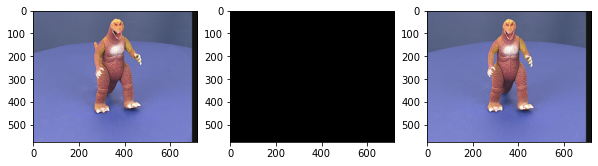

In [131]:
fig, axs = plt.subplots(1, 3, figsize=(10, 10)) 
axs[0].imshow(np.transpose(tgt[0].cpu().numpy(), (1, 2, 0)))
axs[1].imshow(np.transpose(projected_img[0].cpu().numpy(), (1, 2, 0)))
axs[2].imshow(np.transpose(ref[0].cpu().numpy(), (1, 2, 0)))